## Импорт данных

In [2007]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import ANN_classes as ann
import custom_classes as cc
from importlib import reload
import scipy.interpolate
from matplotlib.ticker import FuncFormatter

In [2008]:
reload(ann)

<module 'ANN_classes' from '/home/quantumfox/JupyterWorkfolder/Py3/ANN/ANN_classes.py'>

In [2009]:
ann.vercheck('0.10.0')

ANN vercheck OK


In [2]:
csvdata = []
with open('data_m.csv') as data_file:
    reader = csv.reader(data_file)
    for row in reader: 
        csvdata.append(row)
csvdata = np.array(csvdata, dtype=float)

## Представление данных

In [359]:
# по всем дням
n = csvdata[0]/1000
gv = csvdata[1]
gt = csvdata[2]
gv_s = np.sort(gv)
gt_s = np.sort(gt)

In [360]:
gtv_lookup = dict(zip(zip(gt,gv),n))

i = 0
n_surf = np.array([])
for row in range(32):
    for col in range(32):
        try:
            n_surf = np.append(n_surf, gtv_lookup[(gt_s[col],gv_s[row])])
        except KeyError:
            n_surf = np.append(n_surf, 0)
n_surf = n_surf.reshape(32,32)

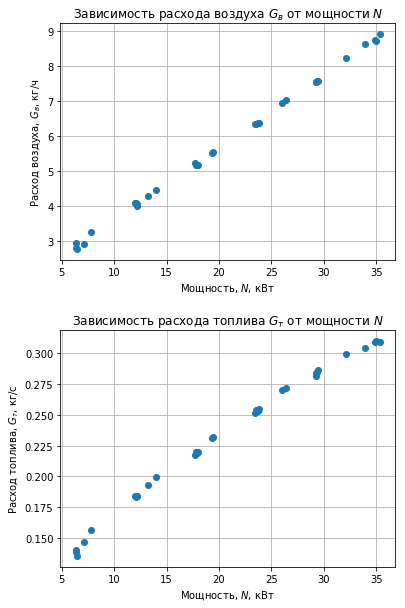

In [362]:
plt.figure(figsize=(6,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.plot(n, gv, 'o')
ax2.plot(n, gt, 'o')
ax1.set_title(u'Зависимость расхода воздуха $G_в$ от мощности $N$')
ax1.set_ylabel(u'Расход воздуха, $G_в$, кг/ч')
ax1.set_xlabel(u'Мощность, $N$, кВт')
ax2.set_title(u'Зависимость расхода топлива $G_т$ от мощности $N$')
ax2.set_ylabel(u'Расход топлива, $G_т$, кг/с')
ax2.set_xlabel(u'Мощность, $N$, кВт')

ax1.grid()
ax2.grid()
plt.subplots_adjust(hspace=0.3)
plt.show()

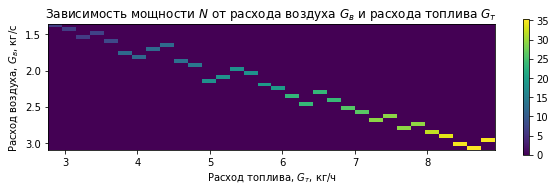

In [363]:
plt.figure(figsize=(10,10))
plt.imshow(n_surf, extent=
          (gv_s.min(), gv_s.max(),
          gt_s.max()*10, gt_s.min()*10))
plt.colorbar(shrink=0.25)
plt.title(u'Зависимость мощности $N$ от расхода воздуха $G_в$ и расхода топлива $G_т$')
plt.xlabel(u'Расход топлива, $G_т$, кг/ч')
plt.ylabel(u'Расход воздуха, $G_в$, кг/с')
# plt.grid()
plt.show()

## Конфигурация и обучение нейросети

In [1716]:
ann1 = ann.NNetwork(1,5,2)
ann1.cfg_input(1)
ann1.cfg_mass()
ann1.cfg_type()
ann1.nwgh_randomize(1,0.2)
# ann1.nwgh_reset(0.4)

precision limit reached


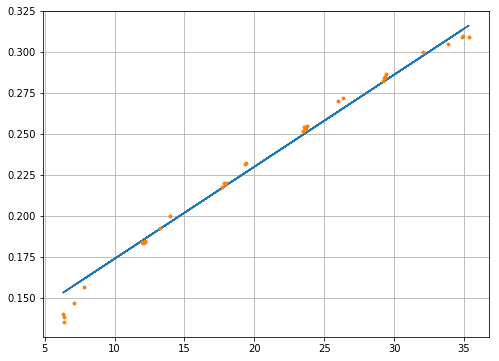

In [1783]:
thresh = 0.15
for _ in range(5000):
    pick = np.random.randint(len(n))
    ann1.forward([n[pick]])
    ann1.getnetgrad([gt[pick], gv[pick]])
    ann1.backward()
    ann1.ncommit()
    err = cc.sqdistance(gt, ann_gt)
    if err < thresh:
        print(u'precision limit reached')
        break

ann_gt = [ann1.forward([n])[0][0] for n in n]
ann_gv = [ann1.forward([n])[0][1] for n in n]
cc.sqdistance(gt, ann_gt)

plt.figure(figsize=(8,6))
plt.plot(n, ann_gt)
plt.plot(n, gt, '.')
plt.grid()
plt.show()

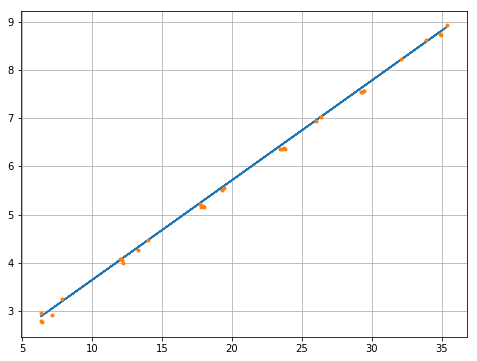

In [1784]:
plt.figure(figsize=(8,6))
plt.plot(n, ann_gv)
plt.plot(n, gv, '.')
plt.grid()
plt.show()

In [1710]:
ann2 = ann.NNetwork(2,8,1)
ann2.cfg_input(2)
ann2.cfg_mass()
ann2.cfg_type()
# ann2.nwgh_randomize(4.,0.2)
ann2.nwgh_reset(1.)

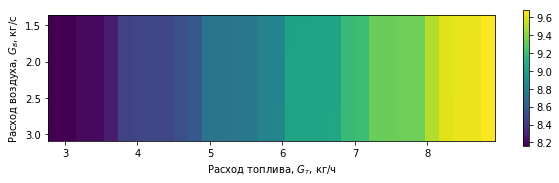

In [1786]:
for _ in range(100):
    pick = np.random.randint(len(gt))
    ann2.forward([gt[pick],gv[pick]])
    ann2.getnetgrad([n[pick]])
    ann2.backward()
    ann2.ncommit()

ann_n = np.array([])
for gt_it in gt_s:
    for gv_it in gv_s:
        ann2.forward([gt_it, gv_it])
        ann_n = np.append(ann_n, ann2.Loo[0].Voo.v)
ann_n = ann_n.reshape(32,32)

plt.figure(figsize=(10,10))
plt.imshow(ann_n, extent=
          (gv_s.min(), gv_s.max(),
          gt_s.max()*10, gt_s.min()*10))
plt.colorbar(shrink=0.25)
# plt.title(u'Зависимость мощности $N$ от расхода воздуха $G_в$ и расхода топлива $G_т$')
plt.xlabel(u'Расход топлива, $G_т$, кг/ч')
plt.ylabel(u'Расход воздуха, $G_в$, кг/с')
plt.show()

## Проверка на искусственном массиве данных

In [1988]:
in_x = np.sort(np.random.random(100)*10)
in_y = [item**2 for item in in_x]

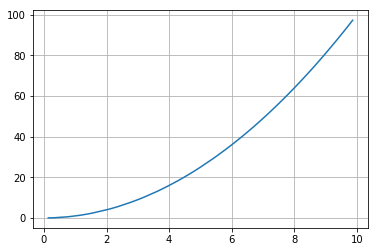

In [1989]:
plt.figure()
plt.plot(in_x, in_y)
plt.grid()
plt.show()

In [1993]:
ann3 = ann.NNetwork(1,5,1)
ann3.cfg_input(1)
ann3.cfg_mass()
ann3.cfg_type()
ann3.nwgh_reset(4.)

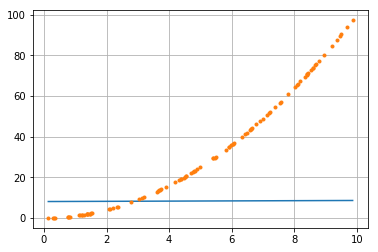

In [2006]:
for _ in range(10):
    pick = np.random.randint(len(in_x))
    ann3.forward([in_x[pick]])
    ann3.getnetgrad([in_y[pick]])
    ann3.backward()
    ann3.ncommit()

ann_in_y = [ann3.forward([in_x[item]])[0][0] for item in range(len(in_x))]

plt.figure()
plt.plot(in_x, ann_in_y)
plt.plot(in_x, in_y, '.')
plt.grid()
plt.show()

In [1947]:
ann3.L1[4].Vw.v

array([ 0.07811675,  0.7272497 ])

In [1857]:
[ann3.forward([in_x[item]])[0][0] for item in range(len(in_x))]

[13.79013029779739,
 13.82232773231304,
 13.82546384052989,
 13.83457950260253,
 13.846922445825376,
 13.870894799632778,
 13.890829319117895,
 13.893520472525619,
 13.915454624573636,
 13.960484876767262,
 13.967242234817721,
 14.015339098798229,
 14.159057773168819,
 14.178170925382284,
 14.283306845300958,
 14.293349681335618,
 14.305269557555908,
 14.365158523147159,
 14.371819412174661,
 14.452027981645285,
 14.496228192527395,
 14.513156176055572,
 14.538316763645513,
 14.604079244568586,
 14.640299004800459,
 14.667617755479101,
 14.682484261037766,
 14.737591156689728,
 14.763569857628076,
 14.77340881114459,
 14.805547197611473,
 14.81868858056583,
 14.829278958829111,
 14.843373891635709,
 14.869920458863854,
 14.911548127242385,
 14.925891471949789,
 14.932445593398596,
 14.941301311350896,
 14.947657186948719,
 15.069333497837061,
 15.080869906282715,
 15.130954777944568,
 15.146502375172398,
 15.161251447344682,
 15.185300483197395,
 15.190679019861308,
 15.199761209141009